In [76]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-pastel')

In [77]:
def objective(x):
    return 2 * np.sin(x) + 3 * np.cos(2 * x) + 5 * \
        np.sin(2 / 3 * x)

In [78]:
n = 100
data_x = np.linspace(0, 4 * np.pi, n)
data_y = objective(data_x)

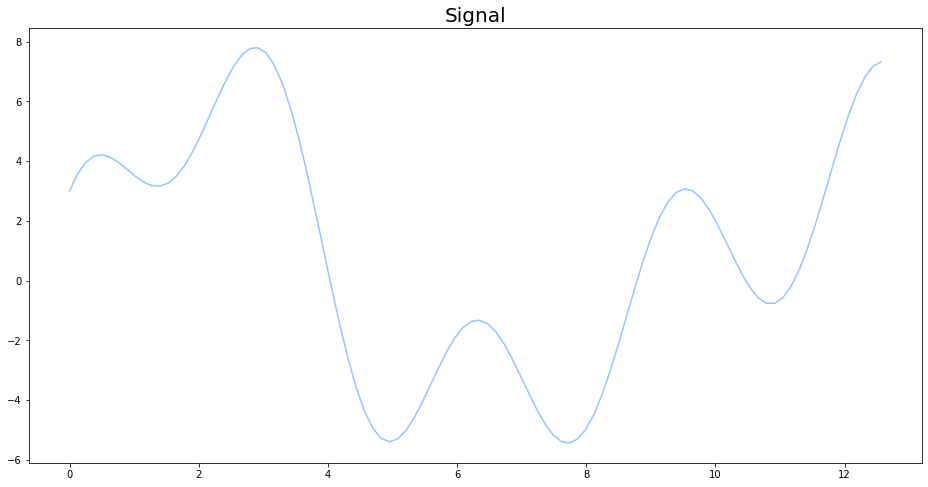

In [79]:
plt.figure(figsize=(16, 8))
plt.title('Signal', fontsize=20)

plt.plot(data_x, data_y, label='correct signal')

In [80]:
def kernel(x, x_prime, p, q, r):
    """Kernel Function

    Args:
        x (float): data
        x_prime (float): data
        p (float): hyper parameter
        q (float): hyper parameter
        r (float): error

    """
    if x == x_prime:
        delta = 1
    else:
        delta = 0

    return p * np.exp(-1 * (x - x_prime)**2 / q) + (r * delta)

In [81]:
def rbf(x, x_prime, theta_1, theta_2):
    """RBF Kernel

    Args:
        x (float): data
        x_prime (float): data
        theta_1 (float): hyper parameter
        theta_2 (float): hyper parameter
    """
    
    return theta_1 * np.exp(-1 * (x - x_prime)**2 / theta_2)

def periodic(x, x_prime, theta_1, theta_2):
    return np.exp(theta_1 * np.cos((x - x_prime) /theta_2))

def linear(x, x_prime, theta):
    return x * x_prime + theta

def exp(x, x_prime, theta):
    return np.exp(-np.abs(x - x_prime) / theta)

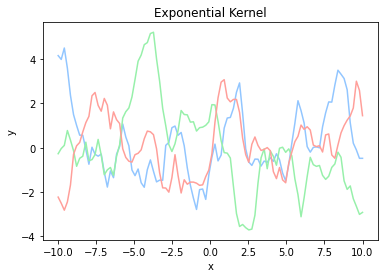

In [82]:
def plot_kernel(kernel, title):
    n = 100
    x = np.linspace(-10, 10, n)
    ys = []
    
    for i in range(3):
        mkernel = np.zeros((x.shape[0], x.shape[0]))
        for i_row in range(x.shape[0]):
            for i_col in range(i_row, x.shape[0]):
                mkernel[i_row, i_col] = kernel(x[i_row], x[i_col])
                mkernel[i_col, i_row] = mkernel[i_row, i_col]
        
        K = 1**2 * np.dot(mkernel, mkernel.T)
        y = np.random.multivariate_normal(np.zeros(len(x)), K)
        ys.append(y)
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    for y in ys:
        ax.plot(x, y)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'{title}')

plot_kernel(lambda x, x_prime: exp(x, x_prime, 0.5), 'Exponential Kernel')

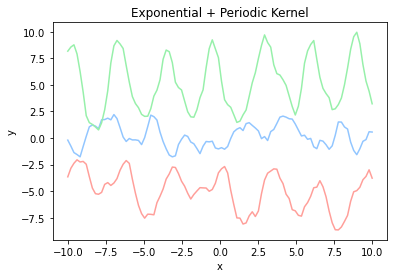

In [75]:
kernel = lambda x, x_prime: 0.8 * exp(x, x_prime, 0.5) + 0.2 * periodic(x, x_prime, 0.5, 0.5)
plot_kernel(kernel, 'Exponential + Periodic Kernel')

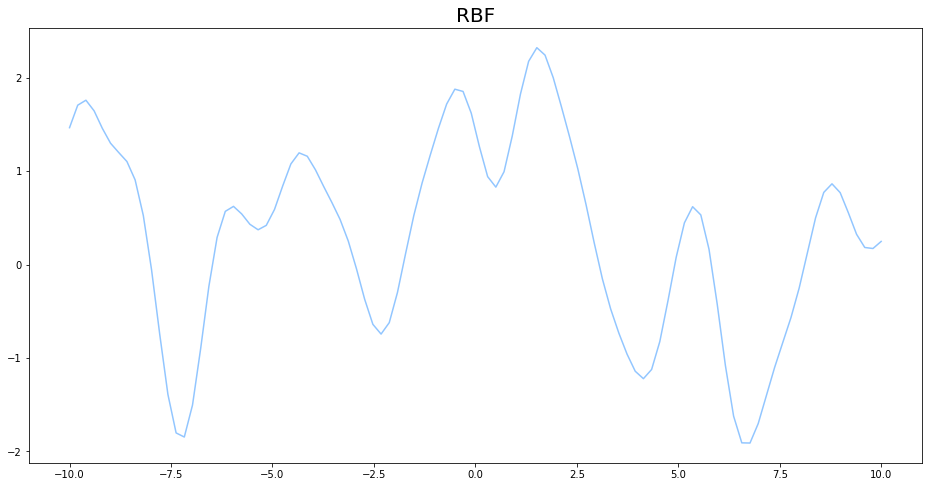

In [48]:
n = 100
x = np.linspace(-10, 10, n)
mkernel = np.zeros((x.shape[0], x.shape[0]))
for i_row in range(x.shape[0]):
        for i_col in range(i_row, x.shape[0]):
            mkernel[i_row, i_col] = rbf(x[i_row], x[i_col], 0.5, 0.5)
            mkernel[i_col, i_row] = mkernel[i_row, i_col]

K = 1**2 * np.dot(mkernel, mkernel.T)
y = np.random.multivariate_normal(np.zeros(len(x)), K)
plt.figure(figsize=(16, 8))
plt.title('RBF', fontsize=20)

plt.plot(x, y, label='RBF Sampling')